# Comparison of SPI and SPEI with GDO and CSIC data sets

This script is using drought indicators from the ERA5--Drought dataset from the European Centre for Medium-range Weather Forecasts (ECMWF) and compares these to drought indicators published by the Global Drought observatory (GDO) and the Spanish National Research Council (Consejo Superior de Investigaciones Científicas, CSIC). 

GDO provides updates of the SPI over several time scales. GDO data was retrieved from: 
https://drought.emergency.copernicus.eu/tumbo/gdo/download

CSIC regularly updates their drought data base with SPEI indicators. CSIC data was retrieved from:         
https://spei.csic.es/spei_database


The image produced in this notebook is published as Figure 4 in 
> Keune, J., F. Di Giuseppe, C. Barnard, and F. Wetterhall (XXXX): \textbf{ERA5--Drought: Global drought indicators based on ECMWF reanalysis}, submitted to Scientific Data. 

In [17]:
import os 
import math
import string
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc4
import xarray as xr
import matplotlib.pyplot as plt

## Australia

### Settings

In [11]:
adminid     = "AUS"
iyear       = 2019
imonth      = 12

#### ADMIN region

ADMIN regions were downloaded from:
https://www.naturalearthdata.com/downloads/

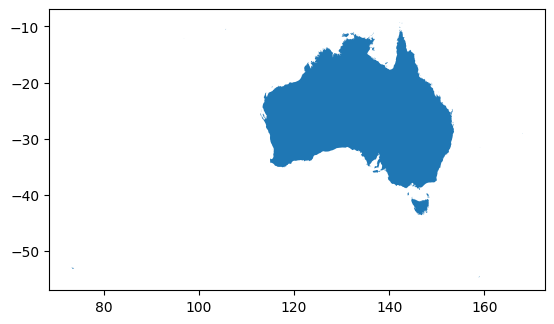

In [12]:
geoshp = gpd.read_file('./data/metadata/ne_10m_admin_0_countries_lakes')
adminshpa = geoshp.loc[ (geoshp.SOVEREIGNT == "Australia"), 'geometry' ]
adminshpa.plot()
adminshp = adminshpa.unary_union
adminshpa=adminshpa.to_crs('epsg:4326')

#### Define boundaries for plot

In [19]:
lon1 = math.floor(adminshp.bounds[0])
lon2 = math.ceil(adminshp.bounds[2])
lat1 = math.floor(adminshp.bounds[1])
lat2 = math.ceil(adminshp.bounds[3])
# Minor adjustments to lon boundaries for aesthetics
lon1 = 110
lon2 = 160
lat1 = -45
print(f"Bounding box: lats {lat1} to {lat2}, lons {lon1} to {lon2}")

Bounding box: lats -45 to -9, lons 110 to 160


### SPI ( ECMWF and GDO )

#### Settings

In [20]:
indicator   = "SPI"
ipath_ecmwf = "/ec/vol/centaur/nejk/drought_monitor"
ipath_edo   = "/ec/vol/centaur/nejk/ref_data/edo_gdo_spi"

In [21]:
ext_dry = "#ff0000"
sev_dry = "#feaa00"
mod_dry = "#fffc03"
near_norm = "#ffffff"
mod_wet = "#e9ccf9"
sev_wet = "#b051c3"
ext_wet = "#7a007a"
spi_collist  = [ext_dry, sev_dry, mod_dry, near_norm, mod_wet, sev_wet, ext_wet]
spi_legnames = ["extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"]
spi_levels   = [-1000, -2, -1.5, -1, 1, 1.5, 2, 1000]

#### Plot all maps in one figure

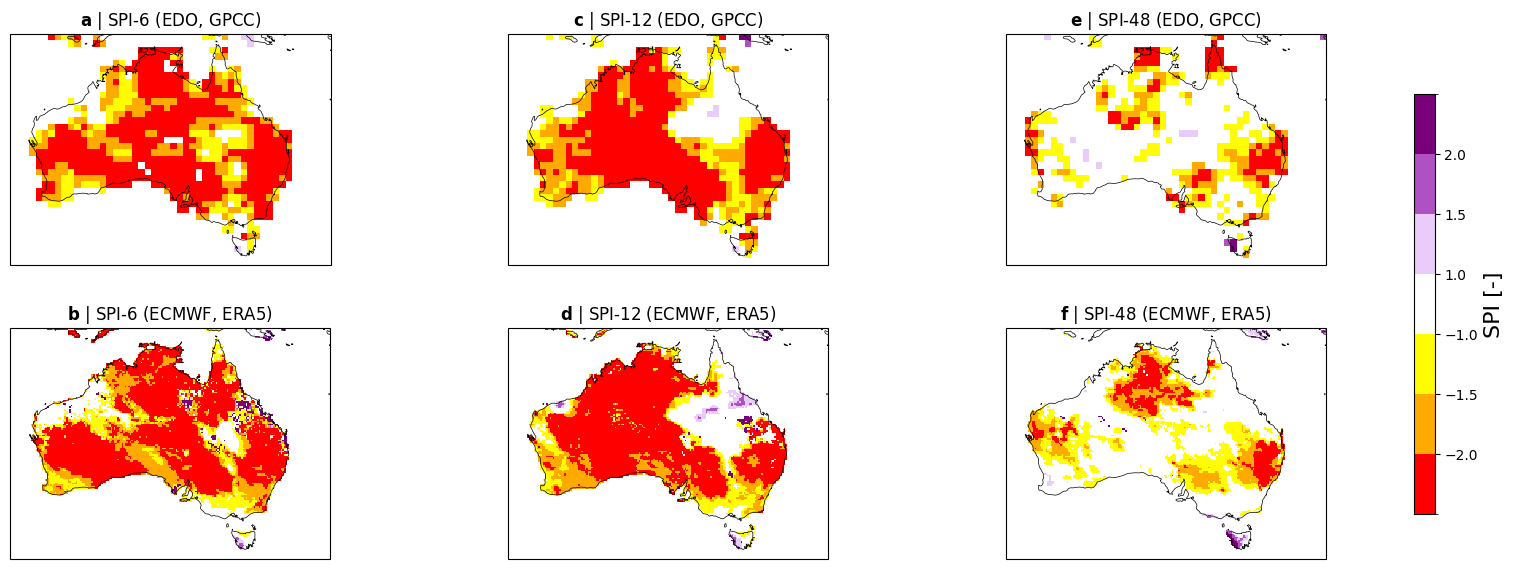

In [22]:
windows = [6,12,48]

fig, axs = plt.subplots(2,3, figsize=(21,6), subplot_kw={'projection': ccrs.PlateCarree()})
iw = 0

#for i, ax in enumerate(fig.axes):
for i, ax in enumerate(axs.T.flatten()):
    window = windows[iw]
    if i % 2 == 0:
        dataset   = "(EDO, GPCC)"
        ifile     = os.path.join(ipath_edo, f"spg{str(window).zfill(2)}_m_wld_{iyear}0101_{iyear}1201_m.nc")
        spi_data  = xr.open_dataset(ifile)[f'spg{str(window).zfill(2)}'].isel(time=imonth-1).sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    else:
        dataset   = "(ECMWF, ERA5)"
        ifile   = os.path.join(f"{ipath_ecmwf}/{indicator.lower()}/{indicator.lower()}{window}", f"{indicator}{window}_gamma_global_era5_moda_ref1991to2020_{iyear}{str(imonth).zfill(2)}.nc")
        spi_data = xr.open_dataset(ifile)[f'{indicator}{window}'].sel(lat=slice(lat2,lat1),lon=slice(lon1,lon2))
        spi_data = xr.where(spi_data == -9999, np.nan, spi_data)
        iw += 1
        
    im = spi_data.plot(levels=spi_levels, colors=spi_collist, ax=ax, add_colorbar= False)
    pretitle=r"$\bf{" + f"{string.ascii_lowercase[i]}" + "}$"
    #ax.set_title(f"{pretitle} | {indicator}-{window} {dataset} | {iyear}-{str(imonth).zfill(2)}")
    ax.set_title(f"{pretitle} | {indicator}-{window} {dataset}")
    ax.coastlines(color='black', lw=0.5)

# add colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.805, 0.1, 0.01, 0.7])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(label=f"{indicator} [-]", size=16)
cbar.set_ticks(spi_levels[1:-1])

plt.subplots_adjust(bottom=0.025, hspace=0.275, wspace=0.05)
plt.show()

### SPEI ( ECMWF vs CSIC )

#### Settings

In [29]:
indicator   = "SPEI"
ipath_ecmwf = "/ec/vol/centaur/nejk/drought_monitor"
ipath_csic  = "/ec/vol/centaur/nejk/ref_data/csic_spei/consolidated"

In [30]:
exc_dry = "#8b1b19"
ext_dry = "#de2928"
sev_dry = "#f3631e"
mod_dry = "#fdc404"
near_norm = "#9afa94"
mod_wet = "#00f2fd"
sev_wet = "#14acf3"
ext_wet = "#1771de"
exc_wet = "#00148b"
spei_collist  = [exc_dry, ext_dry, sev_dry, mod_dry, near_norm, mod_wet, sev_wet, ext_wet, exc_wet]
# the names for these categories are made up by me; to be double-checked
spei_legnames = ["exceptionally dry","extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet", "exceptionally wet"]
spei_levels   = [-1000, -2.33, -1.65, -1.28, -0.84, 0.84, 1.28, 1.65, 2.33, 1000]

#### Plot all maps in one figure

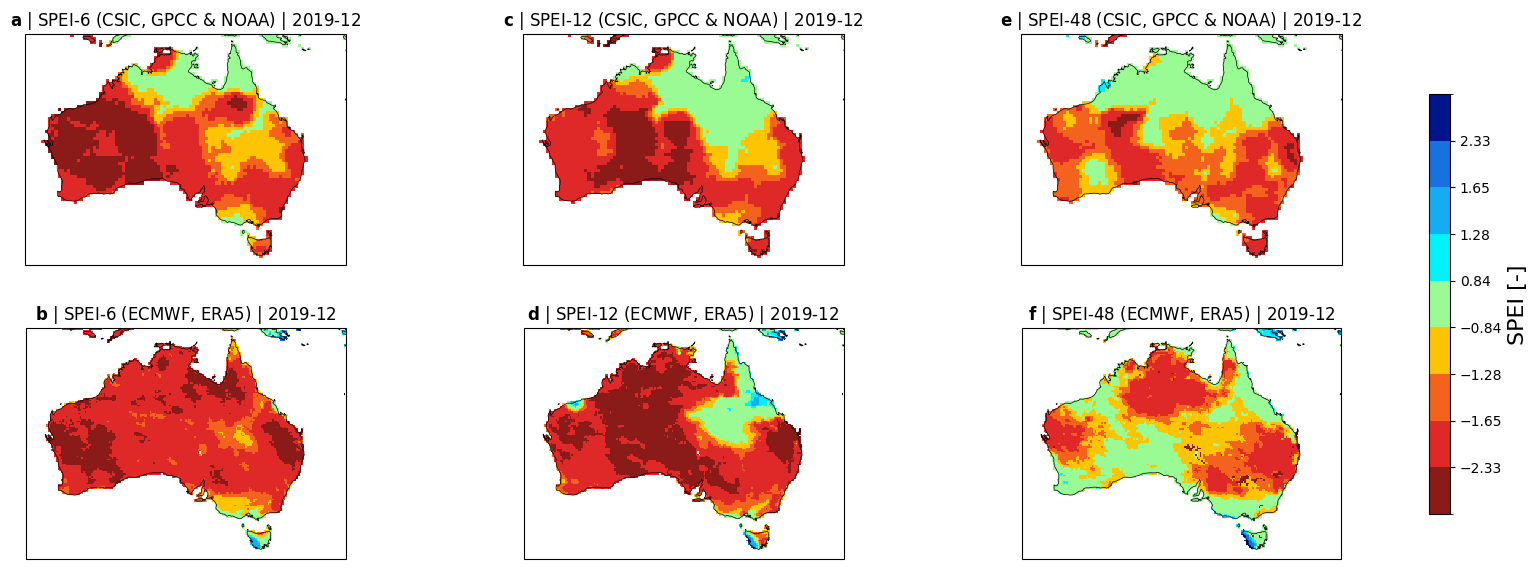

In [34]:
windows = [6,12,48]

fig, axs = plt.subplots(2,3, figsize=(21,6), subplot_kw={'projection': ccrs.PlateCarree()})
iw = 0
#for i, ax in enumerate(fig.axes):
for i, ax in enumerate(axs.T.flatten()):
    window = windows[iw]
    if i % 2 == 0:
        dataset   = "(CSIC, GPCC & NOAA)"
        ifile     = os.path.join(ipath_csic, f"spei{str(window).zfill(2)}.nc")
        spei_data = xr.open_dataset(ifile)[f'{indicator.lower()}'].sel(time=f"{iyear}-{str(imonth).zfill(2)}-15", method='nearest').sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    else:
        dataset   = "(ECMWF, ERA5)"
        ifile     = os.path.join(f"{ipath_ecmwf}/{indicator.lower()}/{indicator.lower()}{window}", f"{indicator}{window}_genlogistic_global_era5_moda_ref1991to2020_{iyear}{str(imonth).zfill(2)}.nc")
        spei_data = xr.open_dataset(ifile)[f'{indicator}{window}'].sel(lat=slice(lat2,lat1),lon=slice(lon1,lon2))
        spei_data = xr.where(spei_data == -9999, np.nan, spei_data)
        iw += 1
        
    im = spei_data.plot(levels=spei_levels, colors=spei_collist, ax=ax, add_colorbar= False)
    pretitle=r"$\bf{" + f"{string.ascii_lowercase[i]}" + "}$"
    ax.set_title(f"{pretitle} | {indicator}-{window} {dataset} | {iyear}-{str(imonth).zfill(2)}")
    ax.coastlines(color='black', lw=0.5)

# add colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.805, 0.1, 0.01, 0.7])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(label=f"{indicator} [-]", size=16)
cbar.set_ticks(spei_levels[1:-1])

plt.subplots_adjust(bottom=0.025, hspace=0.275, wspace=0.05)
plt.show()

### SPI & SPEI plotting

#### Settings

In [26]:
ipath_ecmwf = "/ec/vol/centaur/nejk/drought_monitor"
ipath_edo   = "/ec/vol/centaur/nejk/ref_data/edo_gdo_spi"
ipath_csic  = "/ec/vol/centaur/nejk/ref_data/csic_spei/consolidated"

#### Read and plot

[1, 6, 12, 48, 1, 6, 12, 48, 1, 6, 12, 48, 1, 6, 12, 48]
figures/Figure5_comparison_AUS_201912.pdf


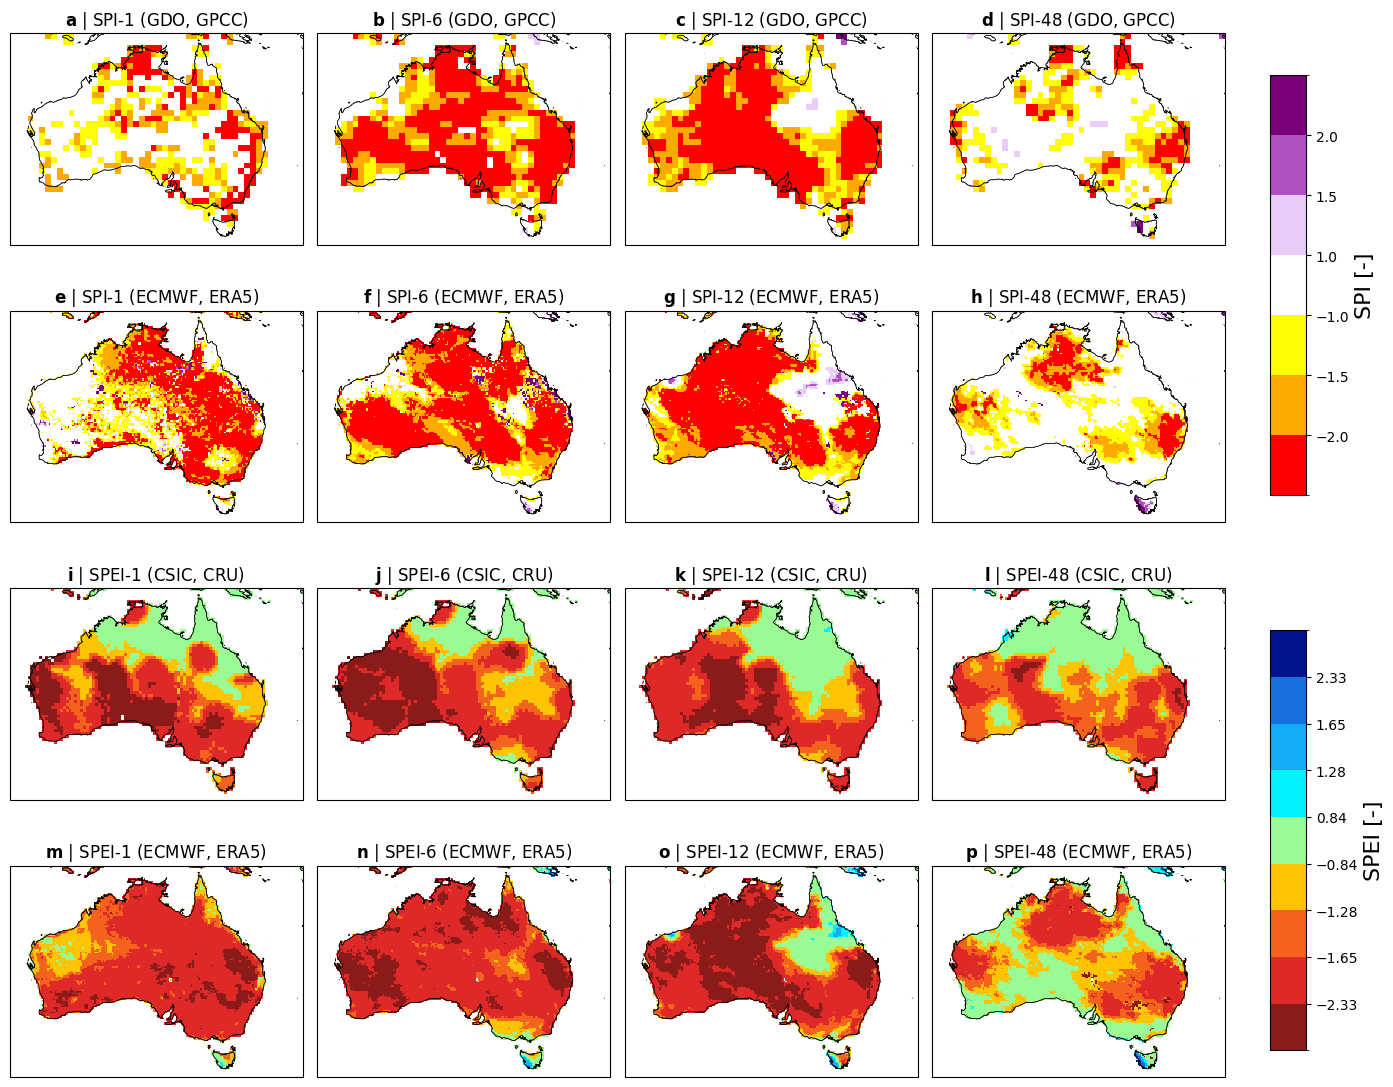

In [36]:
iwindows = [1,6,12,48]
windows  = 4*iwindows
nwindows = len(iwindows)
print(windows)

figname=f"figures/Figure5_comparison_{adminid}_{iyear}{str(imonth).zfill(2)}.pdf"
print(figname)

#windows = [6,12,48,6,12,48,6,12,48,6,12,48]
fig, axs = plt.subplots(4,nwindows, figsize=(18,12), subplot_kw={'projection': ccrs.PlateCarree()})

for i, ax in enumerate(fig.axes):
#for i, ax in enumerate(axs.T.flatten()):

    window = windows[i]

    if i in range(0,nwindows):
        indicator = "SPI"
        dataset   = "(GDO, GPCC)"
        ifile     = os.path.join(ipath_edo, f"spg{str(window).zfill(2)}_m_wld_{iyear}0101_{iyear}1201_m.nc")
        ind_data  = xr.open_dataset(ifile)[f'spg{str(window).zfill(2)}'].isel(time=imonth-1).sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    if i in range(nwindows,2*nwindows):
        indicator = "SPI"
        dataset   = "(ECMWF, ERA5)"
        ifile   = os.path.join(f"{ipath_ecmwf}/{indicator.lower()}/{indicator.lower()}{window}", f"{indicator}{window}_gamma_global_era5_moda_ref1991to2020_{iyear}{str(imonth).zfill(2)}.nc")
        ind_data = xr.open_dataset(ifile)[f'{indicator}{window}'].sel(lat=slice(lat2,lat1),lon=slice(lon1,lon2))
        ind_data = xr.where(ind_data == -9999, np.nan, ind_data)
    if i in range(2*nwindows,3*nwindows):
        indicator = "SPEI"
        dataset   = "(CSIC, CRU)"
        ifile     = os.path.join(ipath_csic, f"spei{str(window).zfill(2)}.nc")
        ind_data = xr.open_dataset(ifile)[f'{indicator.lower()}'].sel(time=f"{iyear}-{str(imonth).zfill(2)}-15", method='nearest').sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    if i in range(3*nwindows,4*nwindows):      
        indicator = "SPEI"
        dataset   = "(ECMWF, ERA5)"
        ifile     = os.path.join(f"{ipath_ecmwf}/{indicator.lower()}/{indicator.lower()}{window}", f"{indicator}{window}_genlogistic_global_era5_moda_ref1991to2020_{iyear}{str(imonth).zfill(2)}.nc")
        ind_data = xr.open_dataset(ifile)[f'{indicator}{window}'].sel(lat=slice(lat2,lat1),lon=slice(lon1,lon2))
        ind_data = xr.where(ind_data == -9999, np.nan, ind_data)
         
    if i in range(0,2*nwindows):
        im = ind_data.plot(levels=spi_levels, colors=spi_collist, ax=ax, add_colorbar= False)
    if i in range(2*nwindows,4*nwindows):
        im2 = ind_data.plot(levels=spei_levels, colors=spei_collist, ax=ax, add_colorbar= False)
    pretitle=r"$\bf{" + f"{string.ascii_lowercase[i]}" + "}$"
    ax.set_title(f"{pretitle} | {indicator}-{window} {dataset}")
    ax.coastlines(color='black', lw=0.5)
    geoshp.plot(facecolor="#00000000", color="#00000000", edgecolor='black', linewidth = 0.35, ax=ax)
    ax.set_xlim([lon1,lon2])
    ax.set_ylim([lat1,lat2])    
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.8, 0.5125, 0.02, 0.35]) #  [left, bottom, width, height] 
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(label=f"SPI [-]", size=16)
cbar.set_ticks(spi_levels[1:-1])
# SPEI colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.775,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.8, 0.05, 0.02, 0.35]) #  [left, bottom, width, height] 
cbar  = fig.colorbar(im2, cax=cb_ax)
cbar.set_label(label=f"SPEI [-]", size=16)
cbar.set_ticks(spei_levels[1:-1])

plt.subplots_adjust(bottom=0.025, hspace=0.275, wspace=0.05)
plt.savefig(figname, format=None, metadata=None,
            #bbox_inches=None, 
            bbox_inches='tight', 
            pad_inches=0.1, dpi=300,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.show()